In [111]:
# thêm thư viện
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.mstats import normaltest
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')

In [112]:
# Đọc dữ liệu từ file CSV
data = pd.read_csv('Data/merged_data.csv')
data.head(5)

,Date,Price,Open,High,Low,Vol.,Change %,XSTC
0,2018-06-05,3592.5,3523.6,3631.8,3425.1,140590.0,4.89,AGR
1,2018-06-06,3612.1,3592.5,3631.8,3543.2,113340.0,0.55,AGR
2,2018-06-07,3641.7,3641.7,3651.5,3592.5,75800.0,0.82,AGR
3,2018-06-08,3562.9,3641.7,3641.7,3543.2,118030.0,-2.16,AGR
4,2018-06-11,3533.4,3562.9,3562.9,3444.8,82080.0,-0.83,AGR


In [113]:
data['Date'] = pd.to_datetime(data['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7450 entries, 0 to 7449
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      7450 non-null   datetime64[ns]
 1   Price     7450 non-null   float64       
 2   Open      7450 non-null   float64       
 3   High      7450 non-null   float64       
 4   Low       7450 non-null   float64       
 5   Vol.      7450 non-null   float64       
 6   Change %  7450 non-null   float64       
 7   XSTC      7450 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 465.8+ KB


In [114]:
# Group by the 'XSTC' column
grouped = data.groupby('XSTC')

# Create a dictionary to hold each group as a separate dataframe
dataframes = {name: group for name, group in grouped}

In [115]:
group_name_0 = list(dataframes.keys())[0]
group_name_0

'AGR'

In [116]:
AGR_df = dataframes[group_name_0]
print(AGR_df.head(2))
print(AGR_df.tail(2))

        Date   Price    Open    High     Low      Vol.  Change % XSTC
0 2018-06-05  3592.5  3523.6  3631.8  3425.1  140590.0      4.89  AGR
1 2018-06-06  3612.1  3592.5  3631.8  3543.2  113340.0      0.55  AGR
           Date    Price     Open     High      Low       Vol.  Change % XSTC
1488 2024-05-20  20150.0  20100.0  20600.0  20100.0  1410000.0      0.25  AGR
1489 2024-05-21  19850.0  20100.0  20100.0  19800.0   499800.0     -1.49  AGR


## **1. Kiểm tra Stationarity**

**Stationarity**
- **Strict stationarity**: the joint distribution of any set of observations in the series remains the same regardless of the time at which the observations are taken.

- **Weak stationarity**: The mean is constant over time; The variance is finite; The covariance of $X(t)$ and $X(t+h)$ depends only on $h$, i.e., is shift-invariance in time.

**Dưới đây, ta kiểm tra tính chất weak stationarity của các time series. Một time series đạt weak stationarity cần thỏa mãn 4 tính chất liệt kê sau đây:**
- Constant mean (no trend). #1
- Constant variance (no heteroskedasticity). #2
- Constant autocorrelation structure (depend on the lag $h$ only). #3

**Để kiểm tra stationarity trong time series chúng ta kết hợp nhiều cách khác nhau. Dưới đây sẽ sử dụng 4 kỹ thuật bao gồm:**
- Run-sequence plots: Trực quan để dự đoán xu hướng, chu kỳ,...
- Summary statistics: Chia time series thành các chunk nhỏ để kiểm tra mean và variance.
- Histogram plots
- Augmented Dickey-Fuller test

#### **1.1. Ngân hàng AGRIBANK**

**Run-sequence plot**

In [117]:
def subsquence_plot_price(df, df_name):
    plt.figure(figsize=(14, 3))
    plt.plot(df['Date'], df['Price'])
    plt.title(f'Stock Price Over Time for {df_name}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)

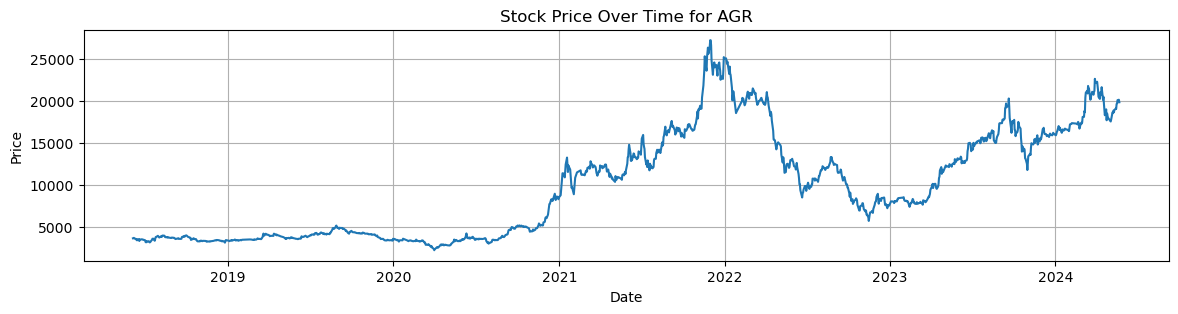

In [118]:
subsquence_plot_price(AGR_df, group_name_0)

Dựa vào biểu đồ trực quan, ta có thể thấy:
- Time series có xu hướng (trend), vì mean thay đổi theo thời gian (vi phạm điều kiện #1).
- Phương sai thay đổi theo thời gian: trước năm 2021 phương sai nhỏ, nhưng sau năm 2021 thì phương sai lớn (vi phạm điều kiện #2).

**Summary Statistics**

In [119]:
def summary_statistics_price(df, df_name):
    if len(df) >= 10:
        # Split data into 10 chunks
        chunks = np.array_split(df['Price'], 10)
        
        # Compare means and variances
        print("{}\t | {}\t\t | {}".format("Chunk", "Mean", "Variance"))
        print("-" * 35)
        for i, chunk in enumerate(chunks, 1):
            print("{:2}\t | {:.5}\t | {:.5}".format(i, np.mean(chunk), np.var(chunk)))
    else:
        print("Not enough data to split into 10 chunks")

In [120]:
summary_statistics_price(AGR_df, group_name_0)

Chunk	 | Mean		 | Variance
-----------------------------------
 1	 | 3476.1	 | 4.8412e+04
 2	 | 3733.1	 | 8.0546e+04
 3	 | 3850.6	 | 3.2726e+05
 4	 | 3553.8	 | 5.5924e+05
 5	 | 9430.1	 | 7.6842e+06
 6	 | 1.6997e+04	 | 1.7443e+07
 7	 | 1.6262e+04	 | 2.4156e+07
 8	 | 8837.7	 | 3.5768e+06
 9	 | 1.3767e+04	 | 9.4157e+06
10	 | 1.7362e+04	 | 5.7454e+06


Dựa vào số liệu thống kê mô tả, ta thấy:
- Mean thay đổi theo thời gian (vi phạm điều kiện #1).
- Variance thay đổi theo thời gian (vi phạm điều kiện #2).

**Histogram Plot**

Nếu histogram gần với phân phối chuẩn thì ta có thể dự đoán mean và variance là không đổi theo thời gian.

In [121]:
def histogram_plot_price(series, df_name):
    plt.figure(figsize=(10, 6))
    plt.hist(series, bins=10, edgecolor='black')
    plt.title(f'Histogram of Prices for {df_name}')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

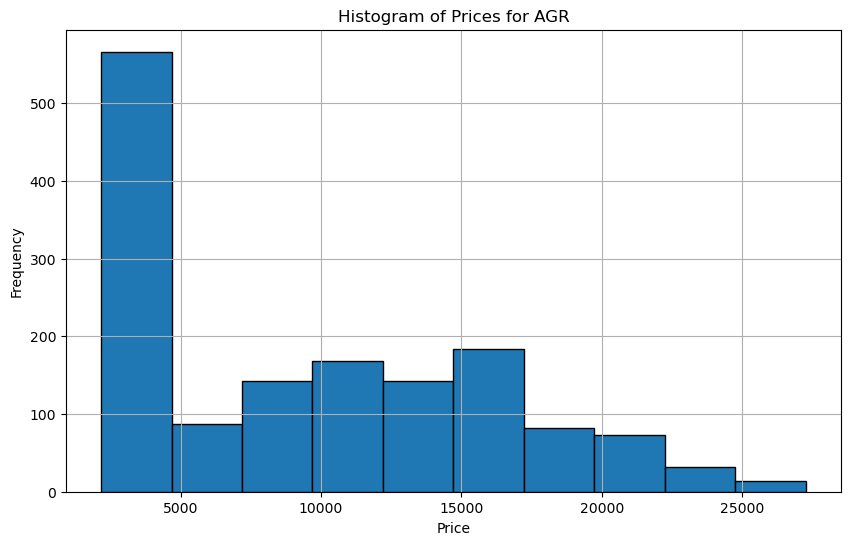

In [122]:
histogram_plot_price(AGR_df['Price'], group_name_0)

Chúng ta có thể sử dụng kiểm định thống kê để kiểm tra:

In [123]:
def normal_test_price(df, df_name):
    k2, p = normaltest(df['Price'])

    print(f"Normality test result for {df_name}:")
    # print(f"Statistic: {k2:.4f}")
    # print(f"P-value: {p:.4f}")

    if p < 0.05:
        print("The null hypothesis of normality is rejected.")
        return False
    else:
        print("The null hypothesis of normality cannot be rejected.")
        return True

In [124]:
normal_test_price(AGR_df, group_name_0)

Normality test result for AGR:
The null hypothesis of normality is rejected.


False

Do đó có thể kết luận được rằng time series trên không tuân theo phân phối chuẩn. Do đó, mean và variance của time series thay đổi theo thời gian (vi phạm điều kiện #1 và #2).

**Augmented Dickey-Fuller (ADF) Test**

- **Null hypothesis** $H_0$: the series is non-stationary.
- **Alternative hypothesis** $H_1$: the series is stationary.
> Chú ý: ADF test có thể không chính xác nếu dataset nhỏ hoặc trong trường hợp phương sai thay đổi (heteroskedasticity). Do đó cần kết hợp nhiều phương pháp bên cạnh ADF test.

In [125]:
def adf_test_price(df, df_name):
    adf_result = adfuller(df['Price'])

    adf, pvalue, usedlag, nobs, critical_values, icbest = adf_result

    print(f"ADF test result for {df_name}:")
    # print("ADF Statistic:", adf)
    # print("p-value:", pvalue)
    # print("Used lag:", usedlag)
    # print("Number of observations:", nobs)
    # print("Critical values:", critical_values)
    # print("IC best:", icbest)

    if pvalue < 0.05:
        print("The null hypothesis of non-stationarity is rejected.")
        return False
    else:
        print("The null hypothesis of non-stationarity cannot be rejected.")
        return True

In [126]:
adf_test_price(AGR_df, group_name_0)

ADF test result for AGR:
The null hypothesis of non-stationarity cannot be rejected.


True

Kết quả của ADF test cho thấy ta không thể bác bỏ $H_0$, do đó time series là non-stationary.

**Vậy, time series về giá cổ phiếu `price` của ngân hàng AGRIBANK là non-stationary.**

#### **1.2. Đánh giá tổng quan tất cả các ngân hàng**

**Sub-sequence plots**

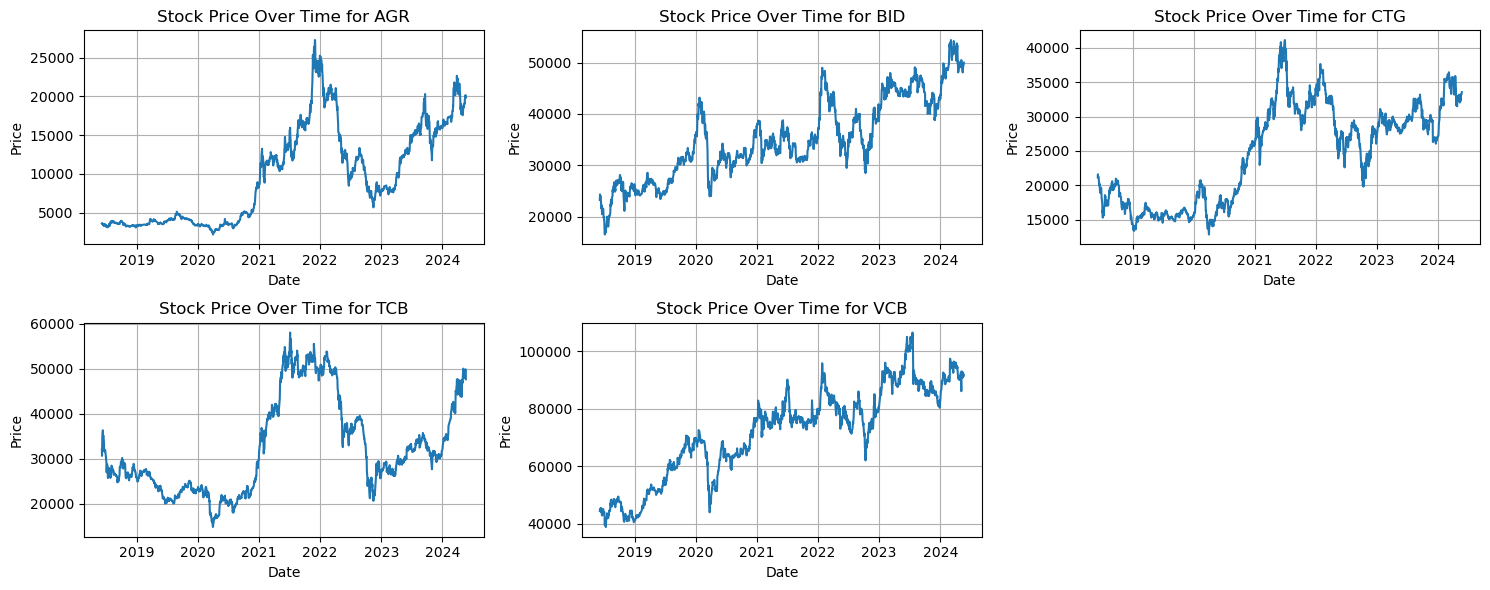

In [127]:
num_plots = len(dataframes)
cols = 3
rows = (num_plots + 1) // cols 

plt.figure(figsize=(15, 3 * rows))

for i, (name, df) in enumerate(dataframes.items(), 1):
    plt.subplot(rows, cols, i)
    plt.plot(df['Date'], df['Price'])
    plt.title(f'Stock Price Over Time for {name}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.grid(True)

plt.tight_layout()  
plt.show()

**Histogram plots**

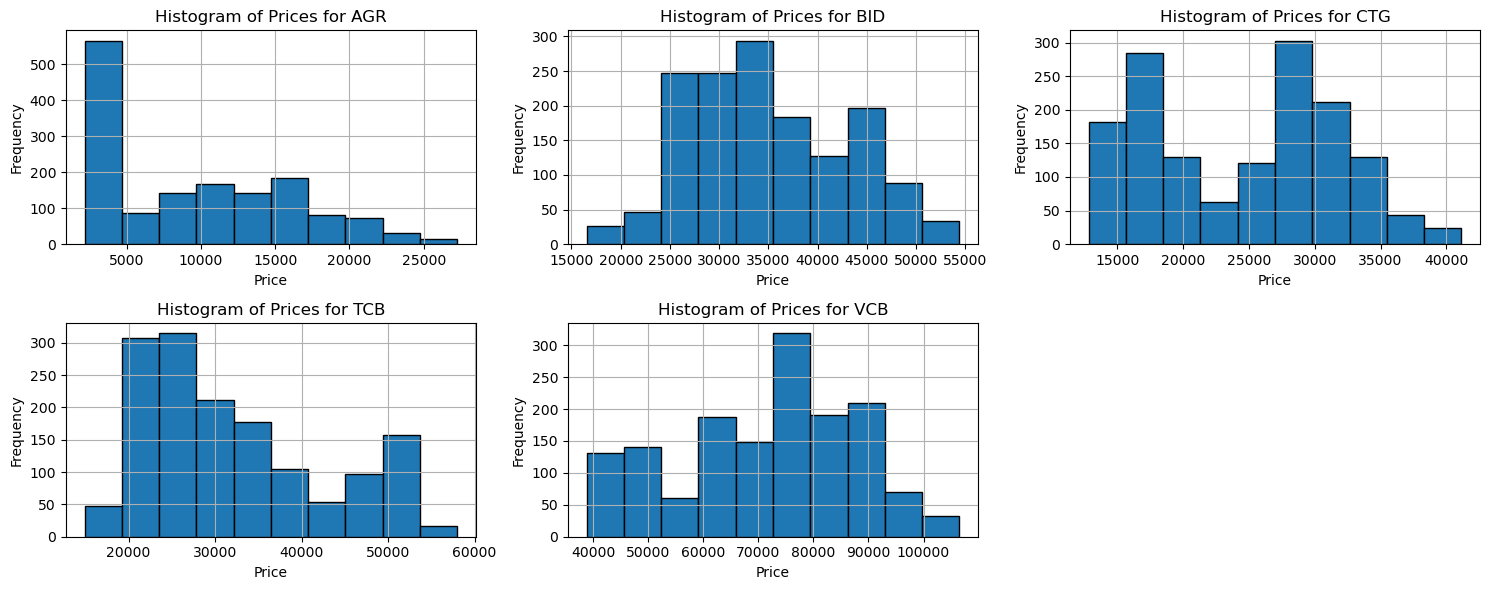

In [128]:
num_plots = len(dataframes)
cols = 3  
rows = (num_plots + 1) // cols 

plt.figure(figsize=(15, 3 * rows))

for i, (name, df) in enumerate(dataframes.items(), 1):
    plt.subplot(rows, cols, i)
    plt.hist(df['Price'], bins=10, edgecolor='black')
    plt.title(f'Histogram of Prices for {name}')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()  
plt.show()

In [129]:
results = []

for df_name, df in dataframes.items():
    print('\n')
    normal_result = normal_test_price(df, df_name)
    adf_result = adf_test_price(df, df_name)
    results.append([df_name, normal_result, adf_result])



Normality test result for AGR:
The null hypothesis of normality is rejected.
ADF test result for AGR:
The null hypothesis of non-stationarity cannot be rejected.


Normality test result for BID:
The null hypothesis of normality is rejected.
ADF test result for BID:
The null hypothesis of non-stationarity cannot be rejected.


Normality test result for CTG:
The null hypothesis of normality is rejected.
ADF test result for CTG:
The null hypothesis of non-stationarity cannot be rejected.


Normality test result for TCB:
The null hypothesis of normality is rejected.
ADF test result for TCB:
The null hypothesis of non-stationarity cannot be rejected.


Normality test result for VCB:
The null hypothesis of normality is rejected.
ADF test result for VCB:
The null hypothesis of non-stationarity cannot be rejected.


In [130]:
results_df = pd.DataFrame(results, columns=['price series', 'normal', 'non-stationary'])
results_df

,price series,normal,non-stationary
0,AGR,False,True
1,BID,False,True
2,CTG,False,True
3,TCB,False,True
4,VCB,False,True


## **2. Prediction**

Ở đây ta sẽ dự đoán giá cổ phiếu cho ngân hàng BIDV (mã BID).

In [131]:
BID_df.tail(5)

,Price,Open,High,Low,Vol.,Change %,XSTC
Date,,,,,,,
2024-05-15,48600.0,49000.0,49000.0,48100.0,1390000.0,1.04,BID
2024-05-16,48840.0,49200.0,50300.0,48600.0,2100000.0,0.49,BID
2024-05-17,49350.0,49750.0,50000.0,49200.0,1520000.0,1.04,BID
2024-05-20,49600.0,49450.0,50700.0,49400.0,2190000.0,0.51,BID
2024-05-21,50000.0,49600.0,50300.0,49600.0,493100.0,0.81,BID


In [132]:
BID_name = 'BID'
BID_df = dataframes[BID_name]

BID_df['Date'] = pd.to_datetime(BID_df['Date'])
BID_df.set_index('Date', inplace=True)
BID_df.tail(5)

,Price,Open,High,Low,Vol.,Change %,XSTC
Date,,,,,,,
2024-05-15,48600.0,49000.0,49000.0,48100.0,1390000.0,1.04,BID
2024-05-16,48840.0,49200.0,50300.0,48600.0,2100000.0,0.49,BID
2024-05-17,49350.0,49750.0,50000.0,49200.0,1520000.0,1.04,BID
2024-05-20,49600.0,49450.0,50700.0,49400.0,2190000.0,0.51,BID
2024-05-21,50000.0,49600.0,50300.0,49600.0,493100.0,0.81,BID


Để áp dụng các mô hình ARMA cho mục đích dự đoán, ta cần phải đưa time series từ `non-stationary` về `stationary`. Một số các phương pháp đó là:

| Transformation       | Effect                 |
|----------------------|------------------------|
| Subtract trend       | Constant mean          |
| Apply log            | Constant variance      |
| Differencing         | Remove autocorrelation |
| Seasonal differencing| Remove periodic component|


In [133]:
# Assuming 'df' is your DataFrame with columns 'Date' and 'Price'

# Set index as date
df.set_index('Date', inplace=True)

# Extract 'Price' column as a separate DataFrame
price_df = df[['Price']]

# Print the price DataFrame
print(price_df)


              Price
Date               
2018-06-05  44429.0
2018-06-06  44808.0
2018-06-07  44505.0
2018-06-08  45263.0
2018-06-11  44732.0
...             ...
2024-05-15  91000.0
2024-05-16  92600.0
2024-05-17  91800.0
2024-05-20  91900.0
2024-05-21  91500.0

[1490 rows x 1 columns]


In [134]:
def adftest(series, plots=True):
    out = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {out[0]:.2f}')
    print(f'p-value: {out[1]:.3f}')
    print(f"Critical Values: {[f'{k}: {r:.2f}' for r,k in zip(out[4].values(), out[4].keys())]}\n")
    
    if plots:
        # Compute rolling statistics
        rolmean = series.rolling(window=12).mean()
        rolstd = series.rolling(window=12).std()

        # Plot rolling statistics:
        plt.figure(figsize=(14, 4))
        plt.plot(series, color='tab:blue', label='Data')
        plt.plot(rolmean, color='tab:red', label='Rolling Mean')
        plt.plot(rolstd, color='black', label='Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean and Standard Deviation')
        plt.grid(True)
        plt.show()


ADF Statistic: -1.61
p-value: 0.479
Critical Values: ['1%: -3.43', '5%: -2.86', '10%: -2.57']



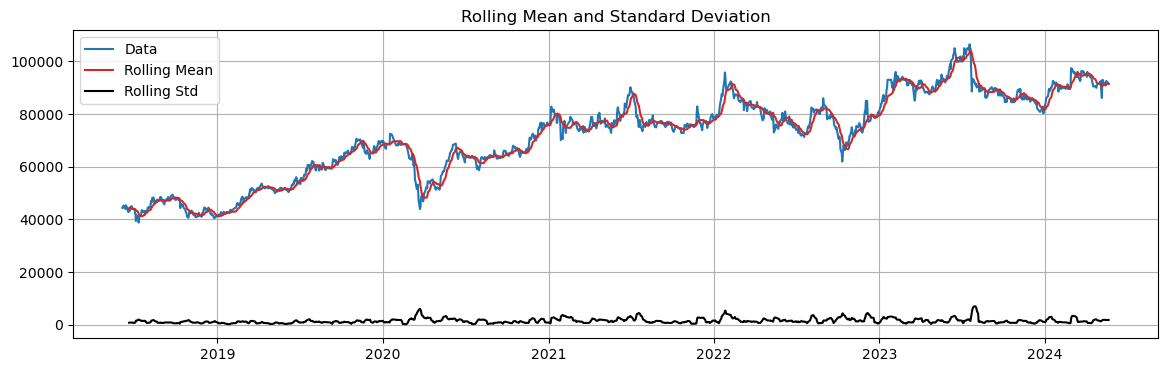

In [135]:
# run ADF on monthly temperatures
adftest(price_df.Price)

In [136]:
# run ADF on annual means
adftest(price_df.Price, plots=False) # no point in plotting the rolling mean/std here

ADF Statistic: -1.61
p-value: 0.479
Critical Values: ['1%: -3.43', '5%: -2.86', '10%: -2.57']



In [137]:
# Perform log transformation
price_log = np.log(price_df.Price)

# Perform first-order differencing
price_log_diff = price_log.diff()

# Print the log-transformed and differenced DataFrame
print(price_log_diff)

Date
2018-06-05         NaN
2018-06-06    0.008494
2018-06-07   -0.006785
2018-06-08    0.016888
2018-06-11   -0.011801
                ...   
2024-05-15    0.002310
2024-05-16    0.017430
2024-05-17   -0.008677
2024-05-20    0.001089
2024-05-21   -0.004362
Name: Price, Length: 1490, dtype: float64


In [138]:
# Perform first-order differencing
price_df['Diff'] = price_log_diff

In [139]:
price_df

,Price,Diff
Date,,
2018-06-05,44429.0,NaN
2018-06-06,44808.0,0.008494
2018-06-07,44505.0,-0.006785
2018-06-08,45263.0,0.016888
2018-06-11,44732.0,-0.011801
...,...,...
2024-05-15,91000.0,0.002310
2024-05-16,92600.0,0.017430
2024-05-17,91800.0,-0.008677


ADF Statistic: -17.14
p-value: 0.000
Critical Values: ['1%: -3.43', '5%: -2.86', '10%: -2.57']



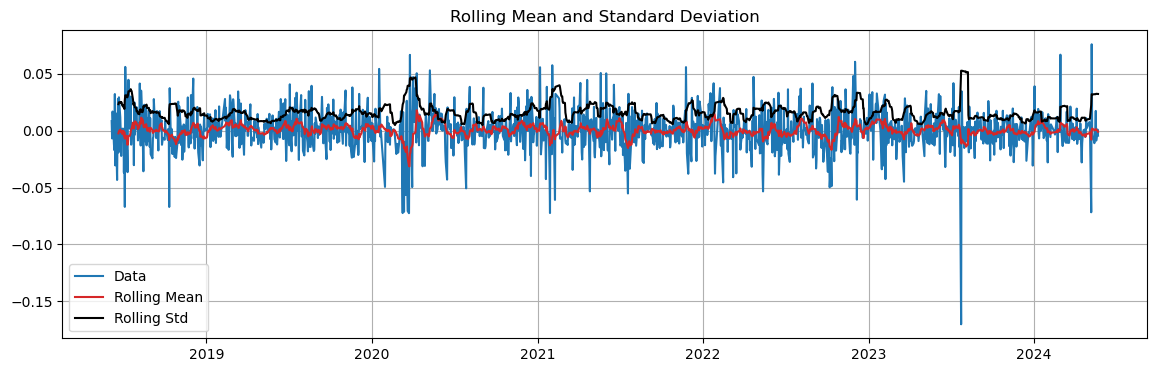

In [140]:
# run ADF on annual means
adftest(price_df.Diff.dropna(), plots=True) # no point in plotting the rolling mean/std here

In [141]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', ValueWarning)
import time
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels as ss
import seaborn as sns
from tqdm.notebook import tqdm
from scipy import stats
from scipy.fft import fft
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import mse
from statsmodels.tsa.statespace.tools import diff
import pmdarima as pm
np.random.seed(0)   

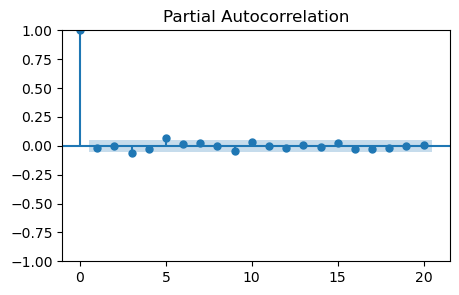

In [142]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_pacf(price_df.Diff.dropna(), lags=20, ax=ax); 

Choose AR(3)

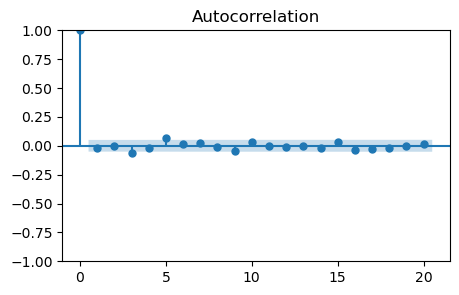

In [143]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_acf(price_df.Diff.dropna(), lags=20, ax=ax); 

Choose MA(3)

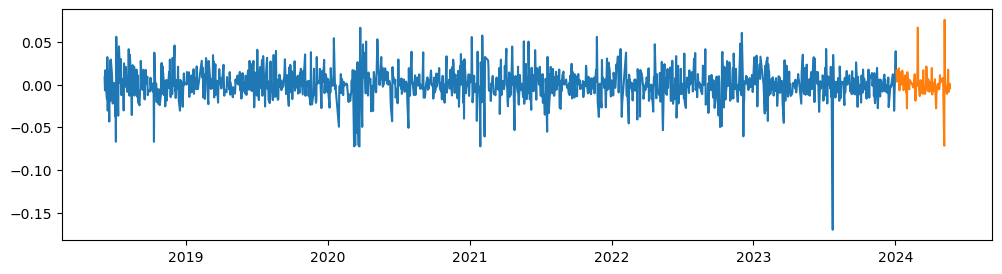

In [144]:
train = price_df.Diff[:-90]
test = price_df.Diff[-90:]

plt.figure(figsize=(12,3))
plt.plot(train)
plt.plot(test);

In [145]:
model = ARIMA(train, order=(3, 0, 3))  # ARIMA with d=0 is equivalent to ARMA
fit_model = model.fit()

print(fit_model.summary())

                               SARIMAX Results                                
Dep. Variable:                   Diff   No. Observations:                 1400
Model:                 ARIMA(3, 0, 3)   Log Likelihood                3656.072
Date:                Fri, 31 May 2024   AIC                          -7296.143
Time:                        01:11:23   BIC                          -7254.189
Sample:                             0   HQIC                         -7280.460
                               - 1400                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      0.852      0.394      -0.001       0.001
ar.L1          0.2998      0.346      0.867      0.386      -0.378       0.977
ar.L2         -0.3583      0.334     -1.072      0.2

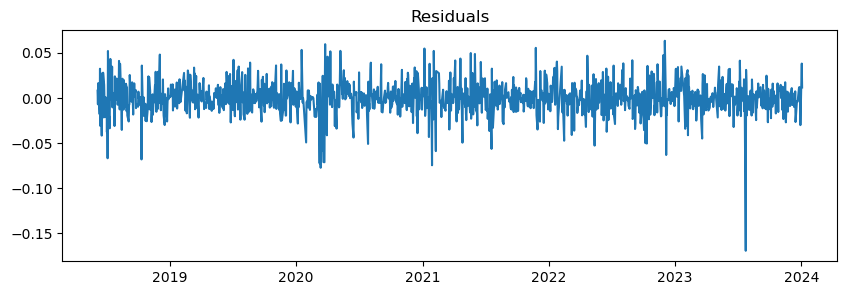

In [146]:
residuals = fit_model.resid

plt.figure(figsize=(10,3))
plt.plot(residuals)
plt.title("Residuals");

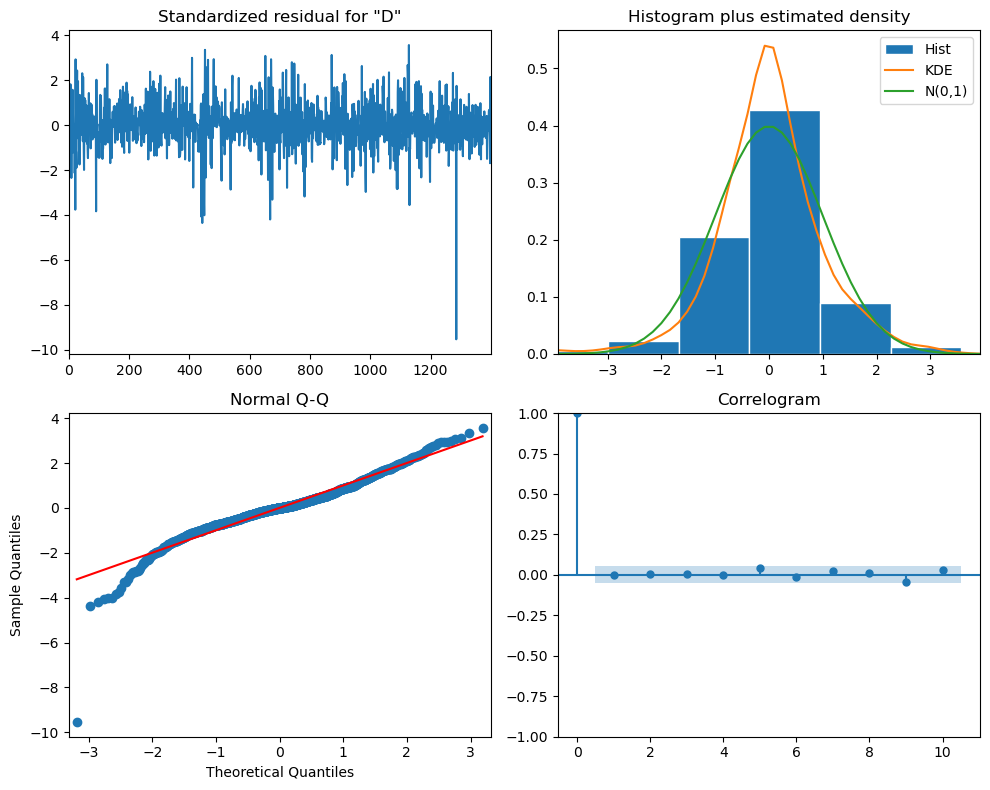

In [147]:
fit_model.plot_diagnostics(figsize=(10, 8))
plt.tight_layout();

Autocorrelation: Ljung-Box test

H0: the residuals are independently distributed (no autocorrelation).

In [148]:
statistic, pval = fit_model.test_serial_correlation(method='ljungbox', lags=10)[0]
print(f'Ljung-Box p-value: {pval.mean():.3f}') 

Ljung-Box p-value: 0.824


Autocorrelation: Durbin Watson test

> The Durbin-Watson statistic typically ranges between 0 and 4. A value close to 2 suggests no autocorrelation. Values significantly different from 2 indicate the presence of autocorrelation. If the Durbin-Watson statistic is close to 0, it indicates positive autocorrelation, while a value close to 4 indicates negative autocorrelation.

In [149]:
durbin_watson = ss.stats.stattools.durbin_watson(fit_model.filter_results.standardized_forecasts_error[0, fit_model.loglikelihood_burn:])
print('Durbin-Watson: d={:.2f}'.format(durbin_watson))

Durbin-Watson: d=2.00


Heteroskedasticity test

> Heteroskedasticity refers to the situation where the variance of the errors (or residuals) in a regression model is not constant across observations. One commonly used test for heteroskedasticity is the Breusch-Pagan test.

H0: : no heteroskedasticity.

In [150]:
_, pval = fit_model.test_heteroskedasticity('breakvar', alternative='increasing')[0]
print(f'H_a: Increasing - pvalue:{pval:.3f}')

H_a: Increasing - pvalue:0.612


Cannot reject that 

In [151]:
_, pval = fit_model.test_heteroskedasticity('breakvar', alternative='decreasing')[0]
print(f'H_a: Decreasing - pvalue:{pval:.3f}')

H_a: Decreasing - pvalue:0.388


In [152]:
_, pval = fit_model.test_heteroskedasticity('breakvar', alternative='two-sided')[0]
print(f'H_a: Two-sided - pvalue:{pval:.3f}')

H_a: Two-sided - pvalue:0.777


Based on the p-values obtained for all three alternative hypotheses, there is no significant evidence to suggest heteroskedasticity in the model residuals.

In [ ]:
def adftest(series, plots=True):
    out = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {out[0]:.2f}')
    print(f'p-value: {out[1]:.3f}')
    print(f"Critical Values: {[f'{k}: {r:.2f}' for r,k in zip(out[4].values(), out[4].keys())]}\n")
    
    if plots:
        # Compute rolling statistics
        rolmean = series.rolling(window=12).mean()
        rolstd = series.rolling(window=12).std()

        # Plot rolling statistics:
        plt.figure(figsize=(14, 4))
        plt.plot(series, color='tab:blue',label='Original')
        plt.plot(rolmean, color='tab:red', label='Rolling Mean')
        plt.plot(rolstd, color='black', label = 'Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean and Standard Deviation')
        plt.grid(); 

Determine seasonality

In [154]:
# adftest(BID_price, plots = False)

In [ ]:
# from scipy.fft import fft, fftfreq
# import numpy as np

# # Perform FFT on the price data
# price_series = BID_price.values
# n = len(price_series)
# price_fft = fft(price_series)
# freqs = fftfreq(n)

# # Only take the positive half of the frequencies
# pos_freqs = freqs[:n // 2]
# pos_price_fft = np.abs(price_fft)[:n // 2]

# # Find the dominant frequency
# dominant_freq = pos_freqs[np.argmax(pos_price_fft[1:]) + 1]  # Ignoring the zero frequency

# # Calculate the period
# dominant_period = 1 / dominant_freq

# print(f'Dominant Frequency: {dominant_freq}')
# print(f'Dominant Period: {dominant_period} days')

Dominant Frequency: 0.0006711409395973154
Dominant Period: 1490.0 days


In [ ]:
# fit_model.plot_diagnostics(figsize=(10, 8))
# plt.tight_layout();

In [155]:
# ! pip install pmdarima

In [ ]:
df = pd.read_csv('Microsoft_Stock.csv')
df.head(8)

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438
5,4/9/2015 16:00:00,41.25,41.62,41.25,41.48,25723861
6,4/10/2015 16:00:00,41.63,41.95,41.41,41.72,28022002
7,4/13/2015 16:00:00,41.40,42.06,41.39,41.76,30276692


### Chỗ này code giống ở dưới chỉ thay tên cột thôi nha (Close --> Price)

In [ ]:
from math import floor,ceil
from pmdarima.arima import auto_arima

def auto_arima_prediction(df):
    shape=df.shape[0]
    df_new=df
    data = df_new.sort_index(ascending=True, axis=0)
    train_set=data[:ceil(shape*0.75)]
    valid_set=data[ceil(shape*0.75):]
    print('----------------------------------------------------------')
    print('-----------STOCK Close PREDICTION BY AUTO ARIMA-----------')
    print('----------------------------------------------------------')
    print('Shape of Training Set',train_set.shape)
    print('Shape of Validation Set',valid_set.shape)
    training = train_set['Close']
    validation = valid_set['Close']
    model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
    model.fit(training)
    forecast = model.predict(n_periods=ceil(floor(df.shape[0]*0.25)))
    forecast = pd.DataFrame(forecast,index = valid_set.index,columns=['Prediction'])
    rms=np.sqrt(np.mean(np.power((np.array(valid_set['Close'])-np.array(forecast['Prediction'])),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    plt.plot(train_set['Close'])
    plt.plot(valid_set['Close'])
    plt.plot(forecast['Prediction'])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Close',size=20)
    plt.title('Stock Close Prediction by Auto ARIMA',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])


----------------------------------------------------------
-----------STOCK Close PREDICTION BY AUTO ARIMA-----------
----------------------------------------------------------
Shape of Training Set (1134, 6)
Shape of Validation Set (377, 6)
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=2.77 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=4440.431, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=4126.393, Time=0.20 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=3.00 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=4427.420, Time=0.06 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3999.903, Time=0.36 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.12 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.59 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=4015.175, Time=0.34 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=3983.513, Time=0.58 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=4107.542, Time=0.34 se

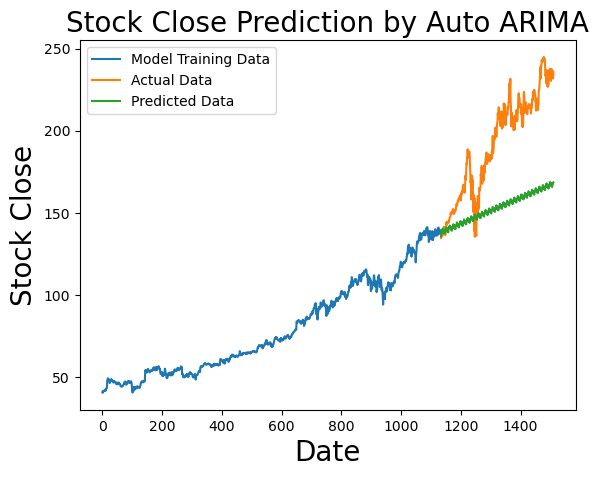

In [ ]:
auto_arima_prediction(df)

### Hàm y hệt ở trên, khác mỗi df['Price'] với df['Close']

In [ ]:
from math import floor,ceil,sqrt
from pmdarima.arima import auto_arima

def auto_arima_prediction_(df):
    shape=df.shape[0]
    df_new=df
    data = df_new.sort_index(ascending=True, axis=0)
    train_set=data[:ceil(shape*0.75)]
    valid_set=data[ceil(shape*0.75):]
    print('----------------------------------------------------------')
    print('-----------STOCK Close PREDICTION BY AUTO ARIMA-----------')
    print('----------------------------------------------------------')
    print('Shape of Training Set',train_set.shape)
    print('Shape of Validation Set',valid_set.shape)
    training = train_set['Price']
    validation = valid_set['Price']
    model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
    model.fit(training)
    forecast = model.predict(n_periods=ceil(floor(df.shape[0]*0.25)))
    forecast = pd.DataFrame(forecast,index = valid_set.index,columns=['Prediction'])
    rms=np.sqrt(np.mean(np.power((np.array(valid_set['Price'])-np.array(forecast['Prediction'])),2)))
    print('RMSE value on validation set:',rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    plt.plot(train_set['Price'])
    plt.plot(valid_set['Price'])
    plt.plot(forecast['Prediction'])
    plt.xlabel('Date',size=20)
    plt.ylabel('Stock Close',size=20)
    plt.title('Stock Close Prediction by Auto ARIMA',size=20)
    plt.legend(['Model Training Data','Actual Data','Predicted Data'])


----------------------------------------------------------
-----------STOCK Close PREDICTION BY AUTO ARIMA-----------
----------------------------------------------------------
Shape of Training Set (1118, 7)
Shape of Validation Set (372, 7)
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=3.06 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=18565.592, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=18239.031, Time=1.50 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.80 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=18566.560, Time=0.11 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=18127.778, Time=3.07 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=4.59 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.75 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=18126.015, Time=0.64 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=18237.053, Time=0.33 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=3.43 s

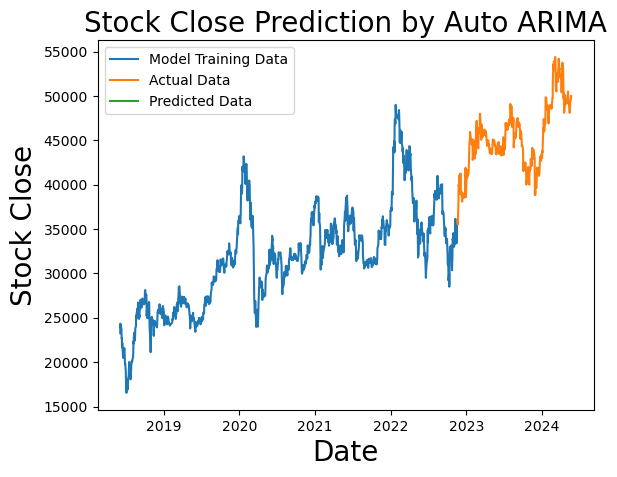

In [ ]:
auto_arima_prediction_(BID_df)

### Long Short Term Memory

In [ ]:
# pip install TensorFlow

In [ ]:
# pip install tf_keras

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tf_keras.models import Sequential
from tf_keras.layers import Dense, LSTM
from math import ceil, sqrt

def lstm_prediction(df):
    shape = df.shape[0]
    df_new = df[['Price']]
    
    # Ensure that there are enough data points
    if shape < 40:
        print("Not enough data to train the model. Need at least 40 data points.")
        return
    
    dataset = df_new.values
    train = df_new[:ceil(shape * 0.75)]
    valid = df_new[ceil(shape * 0.75):]
    
    print('-----------------------------------------------------------------------------')
    print('-----------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------')
    print('-----------------------------------------------------------------------------')
    print('Shape of Training Set:', train.shape)
    print('Shape of Validation Set:', valid.shape)
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(dataset)
    
    x_train, y_train = [], []
    for i in range(40, len(train)):
        x_train.append(scaled_data[i-40:i, 0])
        y_train.append(scaled_data[i, 0])
    
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)
    
    inputs = df_new[len(df_new) - len(valid) - 40:].values
    inputs = inputs.reshape(-1, 1)
    inputs = scaler.transform(inputs)
    
    X_test = []
    for i in range(40, inputs.shape[0]):
        X_test.append(inputs[i-40:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    closing_price = model.predict(X_test)
    closing_price = scaler.inverse_transform(closing_price)
    
    rms = sqrt(np.mean(np.power((valid.values - closing_price), 2)))
    print('RMSE value on validation set:', rms)
    print('-----------------------------------------------------------')
    print('-----------------------------------------------------------')
    
    valid['Predictions'] = closing_price
    plt.figure(figsize=(16, 8))
    plt.plot(train['Price'], label='Train')
    plt.plot(valid['Price'], label='Valid')
    plt.plot(valid['Predictions'], label='Prediction')
    plt.xlabel('Date', size=20)
    plt.ylabel('Stock Price', size=20)
    plt.title('Stock Price Prediction by Long Short Term Memory (LSTM)', size=20)
    plt.legend()
    plt.show()

-----------------------------------------------------------------------------
-----------STOCK PRICE PREDICTION BY LONG SHORT TERM MEMORY (LSTM)-----------
-----------------------------------------------------------------------------
Shape of Training Set: (1118, 1)
Shape of Validation Set: (372, 1)
1078/1078 - 12s - loss: 0.0032 - 12s/epoch - 11ms/step
12/12 [==============================] - 1s 6ms/step
RMSE value on validation set: 1373.070578682687
-----------------------------------------------------------
-----------------------------------------------------------


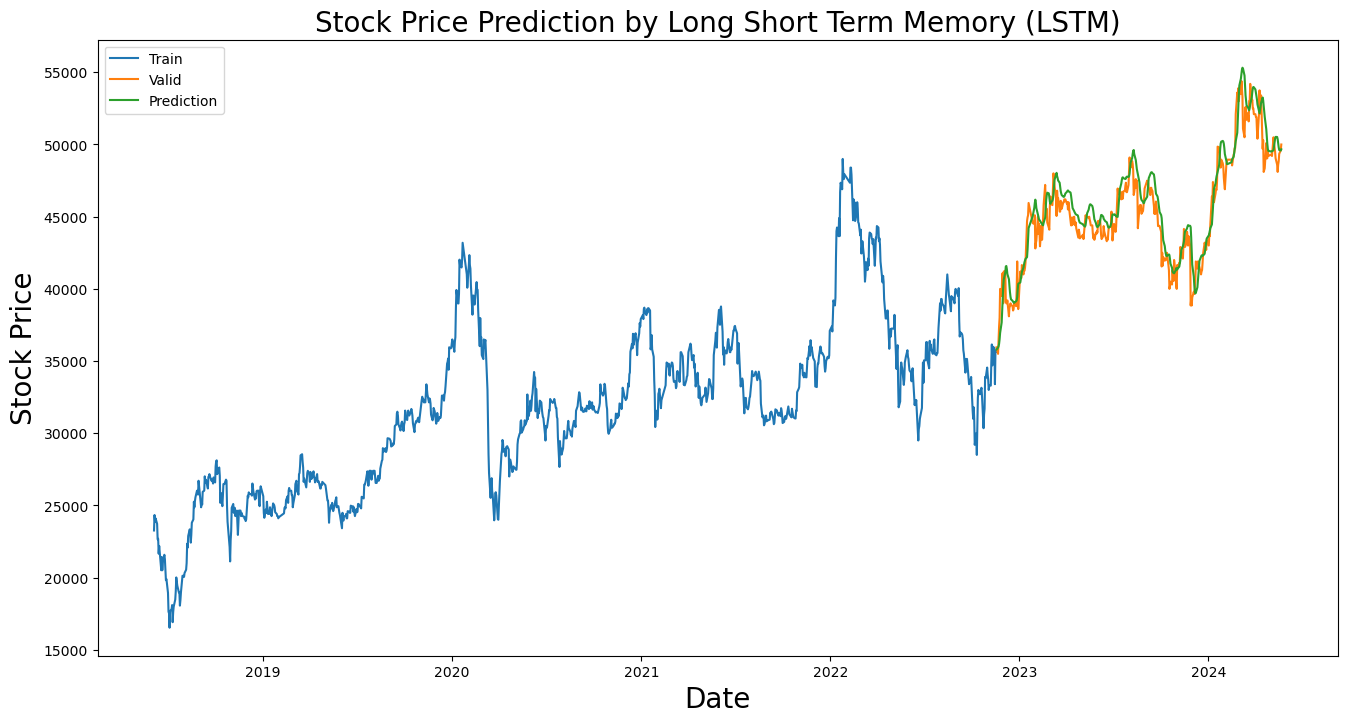

In [ ]:
lstm_prediction(BID_df)